# Creating and processing the dataset

In [3]:
#Creating the dataset
from src.data.make_dataset import generate_synthetic_data, DataRequestInput
from datetime import date
start_date = date(2015, 1, 1)  # Year, Month, Day
end_date = date(2023, 12, 31)  # Year, Month, Day
data_request = DataRequestInput(start_date=start_date, end_date=end_date)
synthetic_data = generate_synthetic_data(data_request)

2024-09-23 14:48:18,799 - ReinformentLearningForPlantOperation - INFO - synthetic data generated


c:\Users\NajibS\OneDrive - Process Integration Limited\DigitalBrain\ReinforcementLearning\SyntheticData\src\data\make_dataset.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=request.start_date, end = request.end_date, freq = 'H')


2024-09-23 14:48:19,450 - ReinformentLearningForPlantOperation - INFO - Data is saved locally at data/raw\synthetic_data.csv


In [4]:
# Preprocessing the dataset
from src.data.preprocess import preprocess_data, PreprocessConfig
preprocess_config = PreprocessConfig() # using the default set values!
train_data, val_data, test_data = preprocess_data(config=preprocess_config)

2024-09-23 14:48:20,614 - ReinformentLearningForPlantOperation - INFO - Finished uploading local data synthetic_data


c:\Users\NajibS\OneDrive - Process Integration Limited\DigitalBrain\ReinforcementLearning\SyntheticData\src\data\preprocess.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file, index_col=0, parse_dates=True)


2024-09-23 14:48:21,161 - ReinformentLearningForPlantOperation - INFO - Data preprocessing completed


# Creating the environment And training the agent

c:\Users\NajibS\.conda\envs\RAG_env\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 6        |
|    time_elapsed    | 30308    |
|    total_timesteps | 189272   |
| train/             |          |
|    actor_loss      | nan      |
|    critic_loss     | nan      |
|    learning_rate   | 0.0001   |
|    n_updates       | 189171   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 6        |
|    time_elapsed    | 58405    |
|    total_timesteps | 378544   |
| train/             |          |
|    actor_loss      | nan      |
|    critic_loss     | nan      |
|    learning_rate   | 0.0001   |
|    n_updates       | 378443   |
---------------------------------


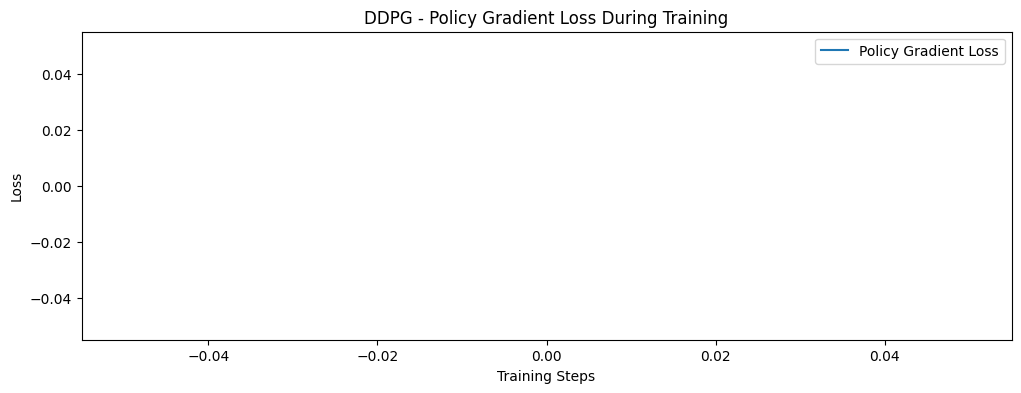

2024-09-26 20:39:28,195 - ReinformentLearningForPlantOperation - INFO - Finished training
Accumulative Reward at the end of 300 steps validation: nan
2024-09-26 20:40:03,452 - ReinformentLearningForPlantOperation - INFO - Accumulative Reward at the end of 300 steps validation: nan
2024-09-26 20:40:03,507 - ReinformentLearningForPlantOperation - INFO - Saved trained agent to src/training/saved_trained_models/PPOAgent_Steps_500000


In [1]:
from src.training.Model_TrainTest import Model_train, ModelEvaluationConfig

actions_list={
    'main_turbine_output': [0, 500],
    'secondary_turbine_output': [0, 500],
    'current_fuel_mixture_ratio': [0, 1],
    'generator_excitation': [0, 1],
    'emissions_control_intensity': [0, 1],
}

internal_states_initialValue={
    'current_power_output': 0,
    'fuel_consumption_rate': 0,
    'emissions_levels': 0,
    'current_operating_costs': 0,
    'emissions_quota': 12000,
    'hours_main_turbine_since_maintenance': 0,
    'hours_secondary_turbine_since_maintenance': 0,
    'current_fuel_mixture_ratio': 0.5,
    'Initial_storage': 0
}

environment_variables={
    'Energy_storage_capacity': 10000,
    'Turbine_maintenance_time': 10,
    'Turbine_use_b4_maintenance': 1000
}

Model_config =ModelEvaluationConfig(
    agent_possible_actions=actions_list,
    train_total_timesteps=500000,
    internalStates_InitialVal = internal_states_initialValue,
    environment_variables=environment_variables
)

TheMatrix = Model_train(Model_config)
# training the agent
train_environment, val_environment, agent, Reward, accumulative_reward = TheMatrix.train_agent()

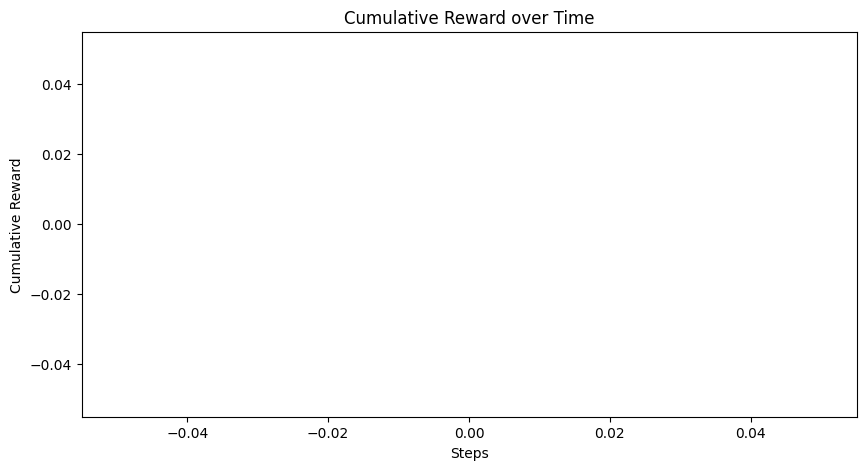

In [2]:
import matplotlib.pyplot as plt

def visualize_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Cumulative Reward over Time')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.show()

visualize_results(Reward)

# Testing

In [3]:
# from src.training.Model_TrainTest import Model_train, ModelEvaluationConfig


# Model_config =ModelEvaluationConfig(
#     agent_possible_actions=actions_list,
#     train_total_timesteps=500000,
#     internalStates_InitialVal = internal_states_initialValue,
#     environment_variables=environment_variables
# )

# TheMatrix = Model_train(Model_config)
# training the agent
# train_environment, val_environment, agent, accumulative_reward = TheMatrix.train_agent()
test_accum_rewards, test_rewards, test_observation_space = TheMatrix.test_agent()


Using cpu device


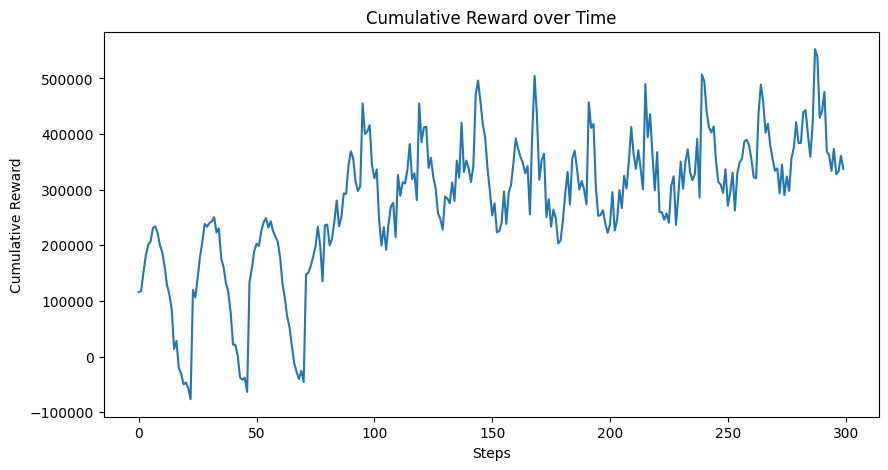

In [4]:
import matplotlib.pyplot as plt

def visualize_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Cumulative Reward over Time')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.show()

visualize_results(test_rewards)

In [5]:
import numpy as np
internal_state_variable =[]
variable_index = 21

for jj in range(len(test_observation_space)):
    step_observation = test_observation_space[jj]
    # print(step_observation.shape)
    internal_state_variable.append(step_observation[0,variable_index])
internal_state_variable = np.array(internal_state_variable)


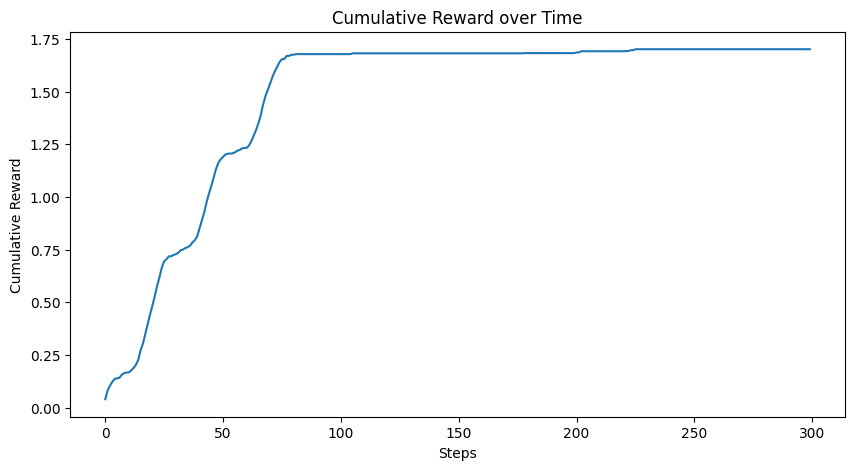

In [6]:
import matplotlib.pyplot as plt

def visualize_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Cumulative Reward over Time')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.show()

visualize_results(internal_state_variable)